# ACE Exploration: Peptide Feature Similarities Exploration

### Dhuvarakesh Karthikeyan and Jin Seok (Andy) Lee

In [1]:
#Import Dependencies

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split

import difflib
import Levenshtein as levenshtein
from collections import Counter
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import mhcflurry
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM

### Load in the Data

In [2]:
data_df = pd.read_csv("../data/post_processing_all_data.csv")[["CDR3b", "Epitope", 'Allele', 'Condition', 'Dataset.Origin']]
data_df = data_df[data_df['Dataset.Origin'] != 'MIRA']
data_df = data_df[["CDR3b", "Epitope", "Allele"]].drop_duplicates()
data_df.sort_values(by=['CDR3b', 'Epitope'])

/tmp/ipykernel_5534/1976381620.py:1: DtypeWarning: Columns (0,6,7,8,9,10,11,12,13,15,17,18,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv("../data/post_processing_all_data.csv")[["CDR3b", "Epitope", 'Allele', 'Condition', 'Dataset.Origin']]


,CDR3b,Epitope,Allele
16764,CAAADEEIGNQPQHF,ATDALMTGY,HLA-A*01:01
51102,CAAAERNTGELFF,YLQPRTFLL,HLA-A*02:01
24923,CAAAHLDSSNEQYF,YVLDHLIVV,HLA-A*02:01
56612,CAAALGGGANEQF,GILGFVFTL,HLA-A*02:01
56613,CAAALGGGANEQF,LLLDRLNQL,HLA-A*02:01
...,...,...,...
49965,CYSYNEQFF,YVLDHLIVV,HLA-A*02:01
50729,CYTF,GLCTLVAML,HLA-A*02:01
50727,CYTF,YVLDHLIVV,HLA-A*02:01
49591,CYVGQALYNEQFF,YVLDHLIVV,HLA-A*02:01


In [3]:
# Filter the numbers of CDR3b for counts over 1
cdr3b_counts = data_df['CDR3b'].value_counts()
cdr3b_counts = cdr3b_counts[cdr3b_counts > 1]
data_df2 = data_df[data_df['CDR3b'].isin(cdr3b_counts.index)]
data_df2.sort_values(by=['CDR3b', 'Epitope'])
data_df2.reset_index(inplace=True, drop=True)
data_df2

,CDR3b,Epitope,Allele
0,CSVGTGGTNEKLF,GLCTLVAML,HLA-A*02:01
1,CSVGTGGTNEKLFF,GLCTLVAML,HLA-A*02:01
2,CASSEGQVSPGELF,GLCTLVAML,HLA-A*02:01
3,CSARDGTGNGYTF,GLCTLVAML,HLA-A*02:01
4,CASSSAHYGYTF,NLVPMVATV,HLA-A*02:01
...,...,...,...
12561,CAWSETGLGMGGWQF,EAAGIGILTV,HLA-A*02:01
12562,CASSLARDIPRDF,AVFDRKSDAK,HLA-A*11:01
12563,CASSLARDIPRDF,IVTDFSVIK,HLA-A*11:01
12564,CLTGAYEQYF,KLGGALQAK,HLA-A*03:01


### Exploratory Data Analysis & Visualization

In [27]:
##################################################################################
##################### Utils for Sampling #########################################
##################################################################################

def sample_ingroup_peptides(cdr3b, df, n=100):
    """
    Sample peptides from the same TCR group.
    
    If there are fewer than n peptides in the group, return all peptides.
    If n is None, return all peptides.
    If there are more than n peptides in the group, return n random peptides.
    """
    if n >= len(df[df['CDR3b'] == cdr3b]):
        return df[df['CDR3b'] == cdr3b]['Epitope'].values
    elif n is None:
        return df[df['CDR3b'] == cdr3b]['Epitope'].values
    else:
        return df[df['CDR3b'] == cdr3b].sample(n=n, replace=False)['Epitope'].values
    
def sample_outgroup_peptides(cdr3b, df, n=100):
    """
    Sample peptides from a different TCR group
    
    Same rules as sample_ingroup_peptides.
    """
    if n >= len(df[df['CDR3b'] != cdr3b]):
        return df[df['CDR3b'] != cdr3b]['Epitope'].values
    elif n is None:
        return df[df['CDR3b'] != cdr3b]['Epitope'].values
    else:
        return df[df['CDR3b'] != cdr3b].sample(n=n, replace=False)['Epitope'].values
    
def get_all_samples(df, n=100):
    '''
    For a given dataframe with CDR3b and Epitope columns,
    get all samples of ingroup and outgroup epitopes.
    '''
    ingroup_epitopes = []
    outgroup_epitopes = []
    # Enumerate all CDR3bs
    cdr3bs = df['CDR3b'].unique()
    total = len(cdr3bs)
    # Calculate similarities for each In-group of CDR3s and Out-group of CDR3s
    for i, cdr3b in enumerate(tqdm(cdr3bs, total=total)):
        ingroup_epitopes.append(list(set(sample_ingroup_peptides(cdr3b, df, n=n))))
        outgroup_epitopes.append(list(set(sample_outgroup_peptides(cdr3b, df, n=n))))
    return ingroup_epitopes, outgroup_epitopes
    
##################################################################################
##################### Utils for Sequence Properties ##############################
##################################################################################

def kmer_similarity(seq1, seq2):
    """Similarity between two sequences based on largest contiguous kmer counts"""
    minln = len(min(seq1, seq2, key=len))
    return difflib.SequenceMatcher(None, seq1, seq2).find_longest_match().size/minln

def levenshtein_distance(seq1, seq2):
    """Levenshtein distance between two sequences"""
    return levenshtein.distance(seq1, seq2)

def levenshtein_similarity(seq1, seq2):
    """Similarity between two sequences based on Levenshtein distance"""
    return 1 - levenshtein.distance(seq1, seq2)/max(len(seq1), len(seq2))

def ratio_similarity(seq1, seq2):
    """Similarity between two sequences based on Levenshtein distance"""
    return difflib.SequenceMatcher(None, seq1, seq2).ratio()

##################################################################################
##################### Bootstrapping Utilities ####################################
##################################################################################

def calculate_similarity(epitopes, similarity_fxn):
    """For all pairs of epitopes, calculate the similarity between them."""
    similarities = []
    for i in range(len(epitopes)):
        for j in range(i+1, len(epitopes)):
            epitope1 = epitopes[i]
            epitope2 = epitopes[j]
            if epitope1 == epitope2:
                continue
            similarities.append(similarity_fxn(epitope1, epitope2))
    return similarities

def calculate_similarities(list_of_samples, similarity='levenshtein'):
    """
    Calculate similarities for a given list of lists where each list is a sample 
    of either ingroup/outgroup epitopes.
    """
    if similarity == 'kmer':
        similarity = kmer_similarity
    elif similarity == 'levenshtein':
        similarity = levenshtein_similarity
    elif similarity == 'levenshtein_d':
        similarity = levenshtein_distance
    elif similarity == 'ratio':
        similarity = ratio_similarity
    else:
        raise ValueError("Similarity must be one of 'kmer', 'levenshtein', or 'ratio'")
    
    similarities = []
    for sample in list_of_samples:
        if len (sample) == 1:
            continue
        similarities.append(calculate_similarity(sample, similarity))
    return similarities
    
def get_similarities(ingroup_peptides, outgroup_peptides, similarity='levenshtein'):
    """
    Calculate in/outgroup similarities for all samples of ingroup/outgroup epitopes.
    """
    ingroup_similarities = [item for sublist in calculate_similarities(ingroup_peptides, similarity=similarity) for item in sublist]
    outgroup_similarities = [item for sublist in calculate_similarities(outgroup_peptides, similarity=similarity) for item in sublist]
    
    return ingroup_similarities, outgroup_similarities


In [5]:
ingroup_peptides, outgroup_peptides = get_all_samples(data_df2, n=100)

100%|██████████| 5556/5556 [00:13<00:00, 420.59it/s]


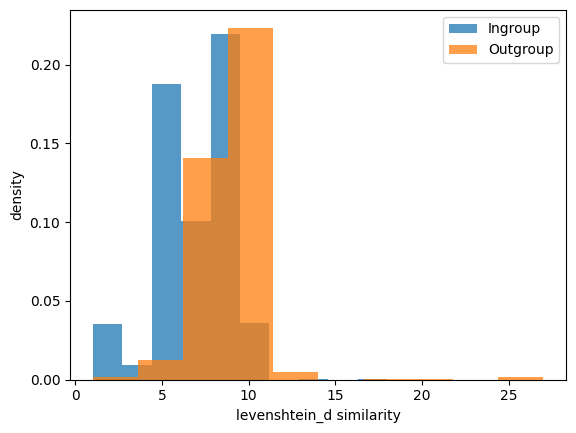

In [28]:
sim = 'levenshtein'
ingroup_lev, outgroup_lev = get_similarities(ingroup_peptides, outgroup_peptides, similarity=sim)
plt.hist(ingroup_lev, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_lev, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

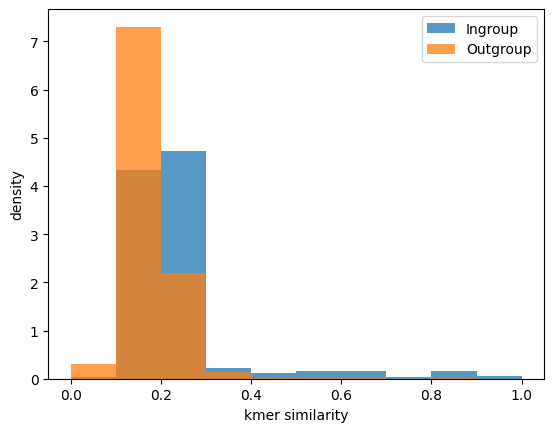

In [35]:
sim = 'kmer'
ingroup_kmer, outgroup_kmer = get_similarities(ingroup_peptides, outgroup_peptides, similarity=sim)
plt.hist(ingroup_kmer, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_kmer, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

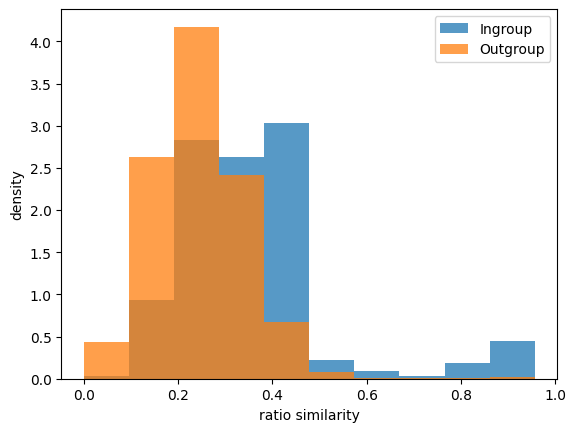

In [36]:
sim = 'ratio'
ingroup_ratio, outgroup_ratio = get_similarities(ingroup_peptides, outgroup_peptides, similarity=sim)
plt.hist(ingroup_ratio, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_ratio, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

## Evaluating Deep Learning Based Methods

In [7]:
_PROTBERT_TOKENIZER = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
_PROTBERT_MODEL = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
PROTBERT_TOKENIZER = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
PROTBERT_MODEL = BertModel.from_pretrained("Rostlab/prot_bert", output_hidden_states=True)
ESM2_TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)

device='cuda' if torch.cuda.is_available() else 'cpu'
ESM2_MODEL.to(device)
PROTBERT_MODEL.to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30, 1024, padding_idx=0)
    (position_embeddings): Embedding(40000, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-29): 30 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inpla

### Defining the ACE Neural Engine

In [9]:
class AceNeuralEngine(nn.Module):
    """
    ACE Neural Engine handles the contextual sequence encoding 
    of the different peptides to generate embeddings. Once the 
    model outputs are calculated the actual represetnation
    can be chosen from the following.


    Representation options:
    - last_hidden_state: last hidden state of the transformer
    - pooler_output: output of the pooler layer
    - cls_embedding: embedding of the [CLS] token
    - mean_pooling: mean pooling of the last hidden state
    - max_pooling: max pooling of the last hidden state

    Representation implementations are based on the HuggingFace Transformers library
    and code from this Kaggle Notebook: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
    """
    def __init__(self, base_model, device, representation='last_hidden_state'):
        super(AceNeuralEngine, self).__init__()
        self.model = base_model
        self.device = device
        self.representation = representation
        self.model.to(self.device)

    def forward(self, inputs):
        """
        Implements the forward function of the nerural engine to get the output of the model
        before grabbing the embedding as the speccified representation.
        """
        
        # 1. Move the inputs to the correct device
        ### inputs: [batch_size, max_seq_len]
        inputs = inputs.to(self.device)
        attention_mask = inputs['attention_mask']
        model_outputs = self.model(**inputs)

        # 2. Get the correct transformer representation
        if self.representation == 'last_hidden_state':    
            representation = model_outputs.hidden_states[-1]
        
        elif self.representation == 'pooler_output':
            if hasattr(model_outputs, 'pooler_output'):
                # repesentation: [batch_size, pooler_dim]
                representation = model_outputs.pooler_output
            else:
                raise ValueError("Base model does not have a pooler_output")
        
        elif self.representation == 'cls_embedding':
            # repesentation: [batch_size, hidden_size]
            representation = model_outputs.hidden_states[-1][:, 0, :]
    
        elif self.representation=='mean_pooling':
            # repesentation: [batch_size, hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            representation = model_outputs.hidden_states[-1].mean(dim=1)

        elif self.representation=='max_pooling':
            representation = torch.max(model_outputs.hidden_states[-1], 1)[0]
                
        elif self.representation == 'mean_max_pooling':
            # repesentation: [batch_size, 2*hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            max_embeddings = torch.max(model_outputs.hidden_states[-1], 1)[0]
            representation = torch.cat((mean_embeddings, max_embeddings), 1)
        
        elif self.representation == 'concatenate_pooling':
            # Strategy: concatenate the last four layers and then pool
            # Alternative strategies: concatenate the last two layers and then pool, 
            # intercalate different layers and pool, etc.

            # repesentation: [batch_size, num_final_layers*hidden_size] 
            queried_hidden_states = torch.stack(model_outputs.hidden_states[-4:])
            representation = torch.cat(tuple(queried_hidden_states), dim=-1)

        #TODO: implement other pooling strategies (e.g. weighted_layer_pooling, attention_pooling)
        # elif self.representation == 'weighted_layer_pooling':
        # elif self.representation == 'attention_pooling':
            
        return representation
    
    
ang_untrained = AceNeuralEngine(ESM2_MODEL, device, representation='last_hidden_state')

In [17]:
##################################################################################
##################### Embedding Utilities ########################################
##################################################################################

def embed_sequences(sequences, model, tokenizer):
    """Calculate embeddings for a list of sequences"""
    if isinstance(tokenizer, BertTokenizer):
        if isinstance(model, BertModel):
            sequences = [re.sub('', ' ', seq) for seq in sequences]
        else:
            raise ValueError("Model must be a BertModel")
    # Tokenize sequences
    tokenized = tokenizer(list(sequences), padding=True, return_tensors='pt')

    # Get embeddings
    with torch.no_grad():
        output = model(tokenized)
        embeddings = output.cpu().numpy()
    return embeddings

def cosine_similarity(emb1, emb2):
    """Cosine similarity between two vectors"""
    a = emb1.reshape(-1)
    b = emb2.reshape(-1)
    return np.dot(a,b.T)/(np.linalg.norm(a)*np.linalg.norm(b))

def euclidean_similarity(emb1, emb2):
    """Euclidean similarity between two vectors"""
    a = emb1.reshape(-1)
    b = emb2.reshape(-1)
    return 1 - np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b))

##################################################################################
##################### Bootstrapping Utilities ####################################
##################################################################################

def calculate_embedding_similarity(embeddings, similarity_fxn):
    """For all pairs of embeddings, calculate the similarity between them."""
    similarities = []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            embedding1 = embeddings[i]ratio
            embedding2 = embeddings[j]
            similarities.append(similarity_fxn(embedding1, embedding2))
    return similarities

def get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=ESM2_MODEL, tokenizer=ESM2_TOKENIZER, similarity='cosine'):
    """
    Calculate in/outgroup similarities for all CDR3b sequences in a dataframe
    """

    if similarity == 'cosine':
        similarity = cosine_similarity
    elif similarity == 'euclidean':
        similarity = euclidean_similarity
    else:
        raise ValueError("Similarity must be one of 'cosine' or 'euclidean'")
    
    ingroup_similarities = []
    outgroup_similarities = []
    
    # Embeddings for all ingroup/outgroup samples
    ingroup_embeddings = [embed_sequences(ingroup_sample, model, tokenizer) for ingroup_sample in ingroup_peptides]
    outgroup_embeddings = [embed_sequences(outgroup_sample, model, tokenizer) for outgroup_sample in outgroup_peptides]

    # Calculate similarities for the list of embeddings
    ingroup_similarities += [calculate_embedding_similarity(ingroup_embedding, similarity) for ingroup_embedding in ingroup_embeddings]
    outgroup_similarities += [calculate_embedding_similarity(outgroup_embedding, similarity) for outgroup_embedding in outgroup_embeddings]
    
    # Flatten the list of lists
    ingroup_similarities = [item for sublist in ingroup_similarities for item in sublist]
    outgroup_similarities = [item for sublist in outgroup_similarities for item in sublist]
    
    return ingroup_similarities, outgroup_similarities

### Pre-Trained (No Fine-Tuning)

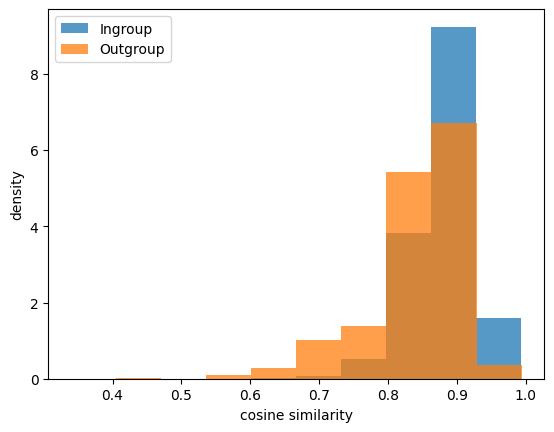

In [54]:
sim = 'cosine'
ingroup_sims, outgroup_sims = get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=ang_untrained, tokenizer=ESM2_TOKENIZER, similarity=sim)
plt.hist(ingroup_sims, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_sims, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

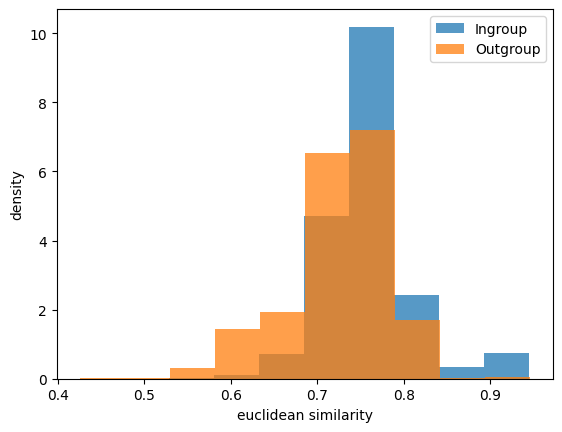

In [55]:
sim = 'euclidean'
ingroup_sims, outgroup_sims = get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=ang_untrained, tokenizer=ESM2_TOKENIZER, similarity=sim)
plt.hist(ingroup_sims, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_sims, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

### Creating a Custom Dataset For Fine-Tuning 

In [10]:
def stratified_train_test_split(df, test_size=0.2, random_state=None):
    # Create a unique identifier for each combination of column_1 and column_2
    df['group_id'] = df['Epitope'].astype(str) + '_' + df['Allele'].astype(str)

    # Find the unique group_ids and their corresponding column_2 values
    groups = df[['group_id', 'Allele']].drop_duplicates()

    # Identify the groups that only have one instance
    group_counts = groups['Allele'].value_counts()
    singleton_groups = group_counts[group_counts == 1].index

    # Separate singleton groups and the rest
    singleton_df = groups[groups['Allele'].isin(singleton_groups)]
    groups = groups[~groups['Allele'].isin(singleton_groups)].sample(frac=1, random_state=random_state)

    # Stratified split on the groups
    train_groups, test_groups = train_test_split(groups, stratify=groups['Allele'], test_size=test_size, random_state=random_state)

    # Add the singleton groups to the train set
    train_groups = pd.concat([train_groups, singleton_df])

    # Use the group_ids to separate the original df
    train_df = df[df['group_id'].isin(train_groups['group_id'])]
    test_df = df[df['group_id'].isin(test_groups['group_id'])]

    # Drop the 'group_id' column we added for grouping
    train_df = train_df.drop(columns='group_id')
    test_df = test_df.drop(columns='group_id')

    return train_df, test_df

In [11]:
train_df, test_df = stratified_train_test_split(data_df2, test_size=0.2, random_state=42)

/tmp/ipykernel_5534/812853081.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group_id'] = df['Epitope'].astype(str) + '_' + df['Allele'].astype(str)


In [37]:
class AceDataset(torch.utils.data.Dataset):
    """
    Dataset class for ACE data. Designed to train
    the ACE Deep Learning Module for sequence
    dissimilarity prediction. Designed to be used
    as a PyTorch Dataset object for triplet loss.
    """

    def __init__(self, data_df, tokenizer, use_hard_negatives=False, max_len=15):
        self.data_df = self.load_from_df(data_df)
        self.tokenizer = tokenizer
        self.max_length = max_len
        self.use_hard_negatives = use_hard_negatives

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        anchor = self.data_df.iloc[index]
        pos = self.get_positive_example(index)
        neg = self.get_negative_example(index)
        return anchor['Epitope'], pos, neg

    def get_positive_example(self, anchor_index):
        """
        Get a positive example for a given anchor index.
        
        Here we define a positive example as a peptide
        with the same CDR3b sequence and the same allele.
        """
        anchor = self.data_df.iloc[anchor_index]
        ddf = self.data_df.drop(anchor_index, axis=0, inplace=False)
        in_convergence_group = ddf[(ddf['CDR3b'] == anchor['CDR3b']) & (ddf['Allele'] == anchor['Allele'])]
        if len(in_convergence_group) == 0:
            return self.perturb_input(anchor_index, positive=True)
        positive = in_convergence_group.sample(1)['Epitope'].values[0]
        return positive
    
    def get_negative_example(self, anchor_index):
        """
        Get a negative example for a given anchor index.

        Here we define a negative example as a peptide
        with a different CDR3b sequence and a different allele.
        """
        anchor = self.data_df.iloc[anchor_index]
        ddf = self.data_df.drop(anchor_index, axis=0, inplace=False)
        
        if self.use_hard_negatives:
            not_in_convergence_group = ddf[(ddf['CDR3b'] != anchor['CDR3b']) & (ddf['Allele'] == anchor['Allele'])]
            if len(not_in_convergence_group) == 0:
                # Return a random epitope
                return self.perturb_input(anchor_index, positive=False)
            else:
                # Levendist = []
                # for i in range(len(not_in_convergence_group.index)):
                #     Levendist.append(levenshtein.distance(anchor['CDR3b'], not_in_convergence_group.iloc[i]['CDR3b']))
                # negative = not_in_convergence_group.iloc[np.argmin(Levendist)]['Epitope']
                negative = not_in_convergence_group.sample(1)['Epitope'].values[0]
        else:
            not_in_convergence_group = ddf[(ddf['CDR3b'] != anchor['CDR3b']) & (ddf['Allele'] != anchor['Allele'])]
            if len(not_in_convergence_group) == 0:
                return self.perturb_input(anchor_index, positive=False)
            negative = not_in_convergence_group.sample(1)['Epitope'].values[0]
        return negative
        
    def perturb_input(self, anchor_index, positive=False):
        """
        Perturb the input sequence for a given anchor index.
        """
        anchor = self.data_df.iloc[anchor_index]
        if positive:
            # Change up a single amino acid in the epitope
            perturbed = self.perturb_peptide(anchor['Epitope'])
        else:
            # Return a random epitope [can be the original]
            perturbed = self.data_df.sample(1)['Epitope'].values[0]
        return perturbed
    
    def perturb_peptide(self, peptide):
        """
        Perturb a peptide sequence.
        """
        peptide = list(peptide)
        perturbed_peptide = peptide.copy()
        perturbed_peptide[random.randint(0, len(peptide)-1)] = random.choice(list('ACDEFGHIKLMNPQRSTVWY'))
        return ''.join(perturbed_peptide)
        
    def weighted_sampler(self, weighted_on):
        """
        Make a weighted sampler that is weighed on the product of multiple classes if need be.
        In this case it is on the Allele and Epitope but it can be changed to be for just the 
        epitope or just the allele or none at all.
        """
        
        num_samples = len(self.data_df)
        if weighted_on==None:
            combined_weights = [1]*num_samples
        else:
            weights = []
            for weight in weighted_on:
                weighting = self.data_df[weight].value_counts(normalize=True)
                weights.append([1/np.sqrt(weighting[label]) for label in self.data_df[weight]])
            weights_array = np.array(weights)
            combined_weights = np.prod(weights_array, axis=0)
        
        return torch.utils.data.WeightedRandomSampler(weights=combined_weights, num_samples=num_samples, replacement=True)
    
    def collate_fn(self, batch):
        """
        Processing a batch of data in the ACE Dataset.
        """
        bsz = len(batch)
        
        # Extract the data triple [(anchor, positive, triple)*bsz]
        anchors, positives, negatives = zip(*batch)

        # Format the sequence for a BERT model if need be
        if isinstance(self.tokenizer, BertTokenizer):
            anchors = [re.sub('', ' ', anch) for anch in anchors]
            positives = [re.sub('', ' ', pos) for pos in positives]
            negatives = [re.sub('', ' ', neg) for neg in negatives]

        # Tokenize and Pad according to the max_length in the batch
        tokenized_anchors = self.tokenizer(anchors, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
        tokenized_positives = self.tokenizer(positives, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
        tokenized_negatives = self.tokenizer(negatives, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')

        return tokenized_anchors, tokenized_positives, tokenized_negatives
        

    def get_dataloader(self, batch_size, weight_on=None):
        """
        Call a dataloader object using the configurations of the current dataset.
        """
        sampler = self.weighted_sampler(weighted_on=weight_on)

        dataloader = torch.utils.data.DataLoader(dataset=self, 
                                            batch_size=batch_size,
                                            sampler=sampler,
                                            collate_fn=self.collate_fn,
                                            pin_memory=False,
                                            drop_last=False)
        return dataloader


    def load_from_df(self, data_df, use_tcr=True, use_condition=False):
        """
        Load data from a Pandas DataFrame.
        """
        cols_to_keep = ['Epitope', 'Allele']
        if use_tcr:
            cols_to_keep.append('CDR3b')
        if use_condition:
            cols_to_keep.append('Condition')
        
        return data_df[cols_to_keep].drop_duplicates(inplace=False).reset_index(drop=True)



In [38]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.epsilon = 1e-8

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sqrt(torch.sum((anchor - positive) ** 2, dim=1) + self.epsilon)  # Euclidean distance
        neg_dist = torch.sqrt(torch.sum((anchor - negative) ** 2, dim=1) + self.epsilon)  # Euclidean distance
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

# class TripletLoss(nn.Module):
#     def __init__(self, margin=0.2):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
#         neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
#         loss = torch.relu(pos_dist - neg_dist + self.margin)
#         return loss.mean()

# Initialize your model and loss function

_ESM2_TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
_ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)
model = AceNeuralEngine(_ESM2_MODEL, representation='last_hidden_state', device=device).to(device)
loss_fn = TripletLoss(margin=1.0)

In [39]:
### Get the train and test dataset and dataloader
USE_HARD_NEGATIVES=True

train_dset = AceDataset(data_df2, _ESM2_TOKENIZER, use_hard_negatives=USE_HARD_NEGATIVES, max_len=15)
train_loader = train_dset.get_dataloader(64, weight_on=['Allele', 'Epitope'])
train_sample = next(iter(train_loader))

# Load the test data
test_dset = AceDataset(test_df, _ESM2_TOKENIZER, use_hard_negatives=USE_HARD_NEGATIVES, max_len=15)
test_loader = test_dset.get_dataloader(64, weight_on=['Allele', 'Epitope'])
test_sample = next(iter(test_loader))

# Anchor, Positive, Negative
assert len(train_sample)==3
assert len(test_sample)==3

In [42]:
# Set up your optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = []
val_losses = []

num_epochs = 10
log_interval = 5
step = 0

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        anchor, positive, negative = batch
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate the loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)
        
        # Backward pass and optimization
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        step += 1

        # Update the adaptive margin
        # with torch.no_grad():
        #     margin_update = 0.1  # Define your own strategy for updating the margin
        #     loss_diff = distance_pos.mean() - distance_neg.mean()
        #     self.loss_fn.margin += margin_update * loss_diff.item()

        # Print the loss for monitoring
        if step % log_interval == 0:
            training_losses.append(loss.item())
            

            # Do validation
            with torch.no_grad():
                vlosses = []
                for batch in test_loader:
                    anchor, positive, negative = batch
                    anchor_emb = model(anchor)
                    positive_emb = model(positive)
                    negative_emb = model(negative)
                    vloss = loss_fn(anchor_emb, positive_emb, negative_emb)
                    vlosses.append(vloss.item())
                val_losses.append(np.mean(vlosses))
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {np.mean(vlosses)}")


# Save the trained model
#torch.save(model.state_dict(), "trained_model.pt")

Epoch [1/10], Train Loss: 0.8716785311698914, Validation Loss: 0.8385287572940191
Epoch [1/10], Train Loss: 0.746013343334198, Validation Loss: 0.7055895626544952
Epoch [1/10], Train Loss: 0.5549416542053223, Validation Loss: 0.6305310825506846
Epoch [1/10], Train Loss: 0.6379320025444031, Validation Loss: 0.6209347968300184
Epoch [1/10], Train Loss: 0.7039675712585449, Validation Loss: 0.5834127739071846
Epoch [1/10], Train Loss: 0.5546412467956543, Validation Loss: 0.6000104000171026
Epoch [1/10], Train Loss: 0.5821748971939087, Validation Loss: 0.5967628533641497
Epoch [1/10], Train Loss: 0.6029574871063232, Validation Loss: 0.617139016588529
Epoch [1/10], Train Loss: 0.4777143597602844, Validation Loss: 0.61151422560215
Epoch [1/10], Train Loss: 0.4790973365306854, Validation Loss: 0.5485236172874769
Epoch [1/10], Train Loss: 0.541745126247406, Validation Loss: 0.5515783031781515
Epoch [1/10], Train Loss: 0.5109360218048096, Validation Loss: 0.5799536953369776
Epoch [1/10], Train L

KeyboardInterrupt: 

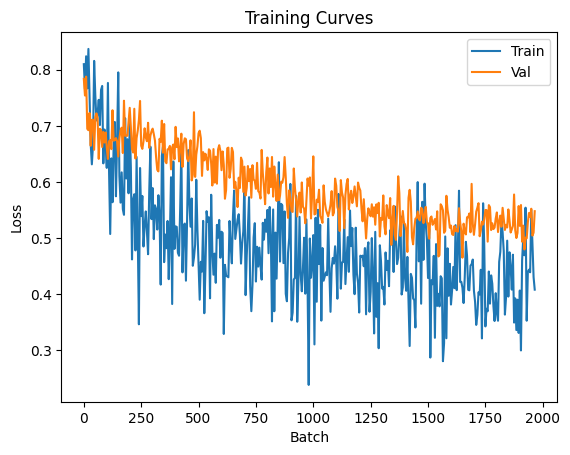

In [41]:
iters = np.arange(0, len(training_losses)*log_interval, log_interval)
plt.plot(iters, training_losses)
plt.plot(iters, val_losses)
plt.xlabel("Batch")
plt.title('Training Curves')
plt.ylabel("Loss")
#plt.ylim(0, 1)
plt.legend(['Train', 'Val'])
plt.show()

In [113]:
#torch.save(model.state_dict(), "trained_model3.pt")

### Load Model from Checkpoint

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("../saved_models/trained_model3.pt", map_location=device))
model.to(device)

AceNeuralEngine(
  (model): EsmForMaskedLM(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 320, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
        (position_embeddings): Embedding(1026, 320, padding_idx=1)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0-5): 6 x EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=320, out_features=320, bias=True)
                (key): Linear(in_features=320, out_features=320, bias=True)
                (value): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=320, out_features=320, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
             

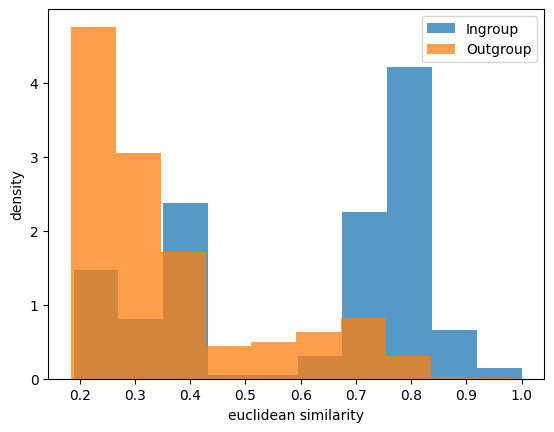

In [18]:
sim = 'euclidean'
ingroup_euclidean, outgroup_euclidean = get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=model, similarity=sim)
plt.hist(ingroup_euclidean, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_euclidean, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

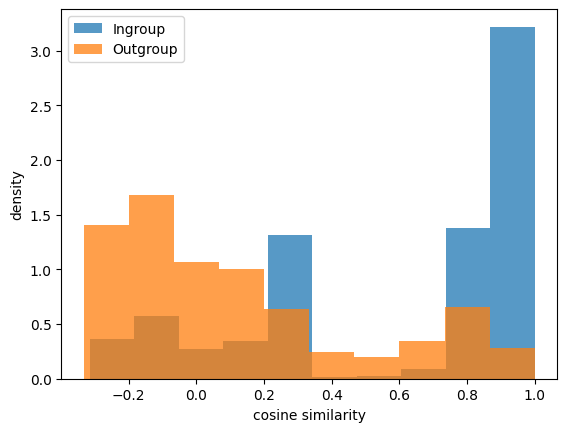

In [19]:
sim = 'cosine'
ingroup_cosine, outgroup_cosine = get_embedding_similarities(ingroup_peptides, outgroup_peptides, model=model, similarity=sim)
plt.hist(ingroup_cosine, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_cosine, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

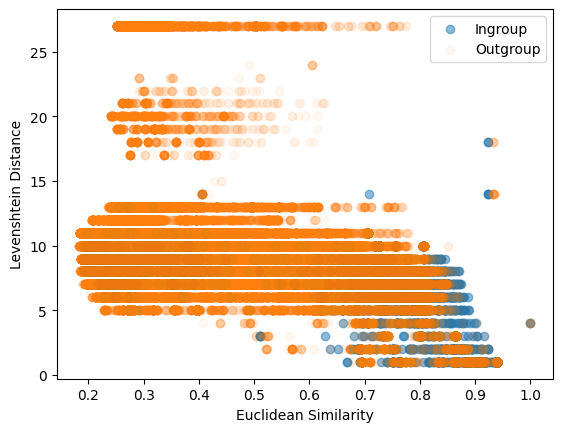

In [33]:
plt.scatter(ingroup_euclidean, ingroup_lev, alpha=0.5, label='Ingroup')
plt.scatter(outgroup_euclidean, outgroup_lev, alpha=0.05, label='Outgroup')
plt.xlabel('Euclidean Similarity')
plt.ylabel('Levenshtein Distance')
plt.legend()

In [127]:
#calculate confusion matrix
def get_confusion_matrix(ingroup_sims, outgroup_sims, threshold):
    """Calculate confusion matrix for a given threshold"""
    TP = sum(np.array(ingroup_sims) > threshold)
    FP = sum(np.array(outgroup_sims) > threshold)
    TN = sum(np.array(outgroup_sims) < threshold)
    FN = sum(np.array(ingroup_sims) < threshold)
    return np.array([[TP, FP], [FN, TN]])

In [135]:
cm = get_confusion_matrix(ingroup_sims, outgroup_sims, 0.2)
cm

array([[    8354,  5600994],
       [    1972, 19485108]])

In [136]:
print(f'Precision:{cm[0,0]/(cm[0,0]+cm[0,1])}')

Precision:0.0014892996476595854


In [137]:
print(f'Recall:{cm[0, 0]/(cm[0, 0]+cm[1, 0])}')

Recall:0.8090257602169282


In [49]:
from sklearn.cluster import KMeans, AgglomerativeClustering

def cluster_embeddings(tensor, num_clusters=None, cluster_size=None, method='kmeans'):
    n_points = tensor.shape[0]
    
    if num_clusters is not None and num_clusters > n_points:
        num_clusters = n_points  # Each point is a separate cluster

    if cluster_size is not None and cluster_size > n_points:
        cluster_size = n_points  # All points in a single cluster

    if num_clusters is not None:
        n_clusters = num_clusters
    elif cluster_size is not None:
        n_clusters = n_points // cluster_size
    else:
        raise ValueError("You must specify at least one of 'num_clusters' or 'cluster_size'")

    matrix = tensor.reshape(n_points, -1)  # Reshape the tensor into a 2-D matrix

    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError("'method' must be 'kmeans' or 'agglomerative'")

    model.fit(matrix)
    return model.labels_

In [63]:
sampled_cdr3bs = np.random.choice(data_df2['CDR3b'].unique(), size=10, replace=False)
sample_df = data_df2[data_df2['CDR3b'].isin(sampled_cdr3bs)]

sample_df

,CDR3b,Epitope,Allele,group_id
9025,CASRKGQGDWEAFF,KRWIILGLNK,HLA-B*27:01,KRWIILGLNK_HLA-B*27:01
12445,CASRKGQGDWEAFF,KAFSPEVIPMF,HLA-B*57:01,KAFSPEVIPMF_HLA-B*57:01
11280,CASSETPGALNIQYF,AVFDRKSDAK,HLA-A*11:01,AVFDRKSDAK_HLA-A*11:01
11242,CASSETPGALNIQYF,KLGGALQAK,HLA-A*03:01,KLGGALQAK_HLA-A*03:01
595,CASSIVSTGELF,GILGFVFTL,HLA-A*02:01,GILGFVFTL_HLA-A*02:01
320,CASSIVSTGELF,GILGFVFTL,HLA-A*02:09,GILGFVFTL_HLA-A*02:09
5656,CASSLVAGDYGYTF,YVLDHLIVV,HLA-A*02:01,YVLDHLIVV_HLA-A*02:01
5655,CASSLVAGDYGYTF,GLCTLVAML,HLA-A*02:01,GLCTLVAML_HLA-A*02:01
8292,CASSPFGPSNQPQHF,KRWIIMGLNK,HLA-B*27:05,KRWIIMGLNK_HLA-B*27:05
8291,CASSPFGPSNQPQHF,KRWIILGLNK,HLA-B*27:05,KRWIILGLNK_HLA-B*27:05


In [64]:
embeddings = embed_sequences(sample_df['Epitope'], model, tokenizer=ESM2_TOKENIZER)

cluster_labels = cluster_embeddings(embeddings, num_clusters=5, method='agglomerative')
cluster_labels

array([2, 4, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 3, 3, 1, 1])

In [66]:
sample_df['cluster_id'] = cluster_labels
sample_df[['CDR3b', 'Epitope', 'Allele', 'cluster_id']]

/tmp/ipykernel_5534/3732046505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['cluster_id'] = cluster_labels


,CDR3b,Epitope,Allele,cluster_id
9025,CASRKGQGDWEAFF,KRWIILGLNK,HLA-B*27:01,2
12445,CASRKGQGDWEAFF,KAFSPEVIPMF,HLA-B*57:01,4
11280,CASSETPGALNIQYF,AVFDRKSDAK,HLA-A*11:01,0
11242,CASSETPGALNIQYF,KLGGALQAK,HLA-A*03:01,0
595,CASSIVSTGELF,GILGFVFTL,HLA-A*02:01,1
320,CASSIVSTGELF,GILGFVFTL,HLA-A*02:09,1
5656,CASSLVAGDYGYTF,YVLDHLIVV,HLA-A*02:01,1
5655,CASSLVAGDYGYTF,GLCTLVAML,HLA-A*02:01,1
8292,CASSPFGPSNQPQHF,KRWIIMGLNK,HLA-B*27:05,2
8291,CASSPFGPSNQPQHF,KRWIILGLNK,HLA-B*27:05,2


### Training an MLP on Ingroups and Outgroups

In [70]:
def get_all_peptide_groupings(df, num_negative=100):
    """
    Get all the peptides groupings as either in-group (1) or outgroup (0).
    Cuts off the number of negatives at num_negatives due to the fact that
    most peptides have a many orders of magnitude larger number of outgroup peptides.
    
    Args:
        df: pd.DataFrame has the columns
            ['CDR3b', 'Epitope', 'Allele']
        num_negative: Number of negative examples to sample for each positive example
    """
    query_peps = []
    comparator_peps = []
    labels = []
    for cdr3b in tqdm(df['CDR3b'].unique()):
        # Get the ingroup and outgroup peptides and then calc
        ingrouped = df[df['CDR3b'] == cdr3b]['Epitope'].values
        outgrouped = df[df['CDR3b'] != cdr3b].sample(n=num_negative)['Epitope'].values
        
        # Pairwise go through the ingrouped peptides

        for i in range(len(ingrouped)):
            for j in range(i+1, len(ingrouped)):
                epitope1 = ingrouped[i]
                epitope2 = ingrouped[j]
                if epitope1 == epitope2:
                    continue
                query_peps.append(epitope1)
                comparator_peps.append(epitope2)
                labels.append(1)

        # Pairwise go through the outgrouped peptides

        for i in range(len(outgrouped)):
            for j in range(i+1, len(outgrouped)):
                epitope1 = outgrouped[i]
                epitope2 = outgrouped[j]
                if epitope1 == epitope2:
                    continue
                query_peps.append(epitope1)
                comparator_peps.append(epitope2)
                labels.append(0)

    return pd.DataFrame({'Query':query_peps,
                         'Reference': comparator_peps,
                         'Label': labels})


In [71]:
res_df = get_all_peptide_groupings(train_df, num_negative=4)

res_df.head(20)

100%|██████████| 5550/5550 [00:06<00:00, 805.07it/s]


,Query,Reference,Label
0,GLCTLVAML,LLLDRLNQL,1
1,GLCTLVAML,GILGFVFTL,1
2,LLLDRLNQL,GILGFVFTL,1
3,GTSGSPIINR,LLLDRLNQL,0
4,GTSGSPIINR,LPRRSGAAGA,0
5,GTSGSPIINR,LPRRSGAAGA,0
6,LLLDRLNQL,LPRRSGAAGA,0
7,LLLDRLNQL,LPRRSGAAGA,0
8,GLCTLVAML,TPRVTGGGAM,1
9,ELAGIGILTV,IVTDFSVIK,0


In [95]:
class AceMLP(nn.Module):
    """
    ACE Multilayer Perceptron for predicting in-group and out-group peptides
    
    Confounded by MHC, but we purposely remain MHC agnostic
    """

    def __init__(self, tokenizer, embedding_module, device, embed_dim=320):
        super(AceMLP, self).__init__()     
        self.device = device
        self.tokenizer = tokenizer
        self.embedding_module = embedding_module.to(self.device)


        self.embed_dim = embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(2*self.embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64,1),
            nn.Sigmoid()
        ).to(device)

    def forward(self, tokenized_queries, tokenized_references):
        #tokenized_queries = self.tokenizer(queries, padding=True, return_tensors='pt').to(self.device)
        #tokenized_references = self.tokenizer(references, padding=True, return_tensors='pt').to(self.device)
        tokenized_queries = {k: v.to(self.device) for k, v in tokenized_queries.items()}
        tokenized_references = {k: v.to(self.device) for k, v in tokenized_references.items()}
        
        with torch.no_grad():
            # Embed the query and reference peptides [batch_size, embed_dim]
            ### Grab the last layer output from the embedding module and take the first token hidden state embedding
            query_emb = self.embedding_module(**tokenized_queries).hidden_states[-1][:, 0, :]
            reference_emb = self.embedding_module(**tokenized_references).hidden_states[-1][:, 0, :]
        
        # Concatenate the embeddings [batch_size, 2*embed_dim]
        concat = torch.cat([query_emb, reference_emb], dim=-1)
        return self.mlp(concat)

class AceMLPDataset(torch.utils.data.Dataset):
    """
    Dataset class for ACE data. Designed to train
    the ACE Deep Learning Module for sequence
    dissimilarity prediction. Designed to be used
    to train a MLP for binary classification of in-group
    and out-group peptides.
    """
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.df = df

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        return row['Query'], row['Reference'], row['Label']
    
    def collate_fn(self, batch):
        queries, references, labels = zip(*batch)
        tokenized_queries = self.tokenizer(queries, padding=True, return_tensors='pt')
        tokenized_references = self.tokenizer(references, padding=True, return_tensors='pt')
        return tokenized_queries, tokenized_references, torch.FloatTensor(labels)
    
    def get_dataloader(self, batch_size):
        dataloader = torch.utils.data.DataLoader(dataset=self, 
                                            batch_size=batch_size,
                                            collate_fn=self.collate_fn,
                                            pin_memory=False,
                                            drop_last=False)
        return dataloader
    
train_dset = AceMLPDataset(res_df, _ESM2_TOKENIZER)
train_loader = train_dset.get_dataloader(64)
test_dset = AceMLPDataset(get_all_peptide_groupings(test_df, num_negative=4), _ESM2_TOKENIZER)
test_loader = test_dset.get_dataloader(64)

# Initialize your model and loss function
model = AceMLP(_ESM2_TOKENIZER, model.model, device).to(device)
loss_fn = nn.BCELoss()

100%|██████████| 661/661 [00:00<00:00, 2980.39it/s]


In [96]:
# Set up your optimizer
learning_rate = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


training_losses = []
val_losses = []

num_epochs = 10
log_interval = 100
step = 0

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        tokenized_queries, tokenized_references, labels = batch
        tokenized_queries = {k: v.to(device) for k, v in tokenized_queries.items()}
        tokenized_references = {k: v.to(device) for k, v in tokenized_references.items()}
        labels = labels.to(device)
        
        logits = model(tokenized_queries, tokenized_references)

        # Calculate the loss
        loss = loss_fn(logits, labels.unsqueeze(-1))
        
        # Backward pass and optimization
        loss.backward()


        optimizer.step()

        step += 1

        # Print the loss for monitoring
        if step % log_interval == 0:
            training_losses.append(loss.item())            

            # Do validation
            with torch.no_grad():
                vlosses = []
                for batch in test_loader:
                    tokenized_queries, tokenized_references,  labels = batch
                    tokenized_queries = {k: v.to(device) for k, v in tokenized_queries.items()}
                    tokenized_references = {k: v.to(device) for k, v in tokenized_references.items()}
                    labels = labels.to(device)
                    logits = model(tokenized_queries, tokenized_references)
                    vloss = loss_fn(logits, labels.unsqueeze(-1))
                    vlosses.append(vloss.item())
                val_losses.append(np.mean(vlosses))
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {np.mean(vlosses)}")


# Save the trained model
#torch.save(model.state_dict(), "trained_model.pt")

Epoch [1/10], Train Loss: 0.6040325164794922, Validation Loss: 0.5894757849829537
Epoch [1/10], Train Loss: 0.47036975622177124, Validation Loss: 0.47243909697447506
Epoch [1/10], Train Loss: 0.5360788106918335, Validation Loss: 0.3925130819635732
Epoch [1/10], Train Loss: 0.3679322898387909, Validation Loss: 0.3438852306987558
Epoch [1/10], Train Loss: 0.588671088218689, Validation Loss: 0.3465439959296158
Epoch [1/10], Train Loss: 0.5076862573623657, Validation Loss: 0.32655079822455135
Epoch [2/10], Train Loss: 0.5420452356338501, Validation Loss: 0.3222417352455003
Epoch [2/10], Train Loss: 0.49651646614074707, Validation Loss: 0.32120711728930473
Epoch [2/10], Train Loss: 0.4286622405052185, Validation Loss: 0.30621154606342316
Epoch [2/10], Train Loss: 0.32617974281311035, Validation Loss: 0.29346643654363497
Epoch [2/10], Train Loss: 0.44134217500686646, Validation Loss: 0.30928119884005617
Epoch [2/10], Train Loss: 0.36488020420074463, Validation Loss: 0.2952877362923963
Epoch 

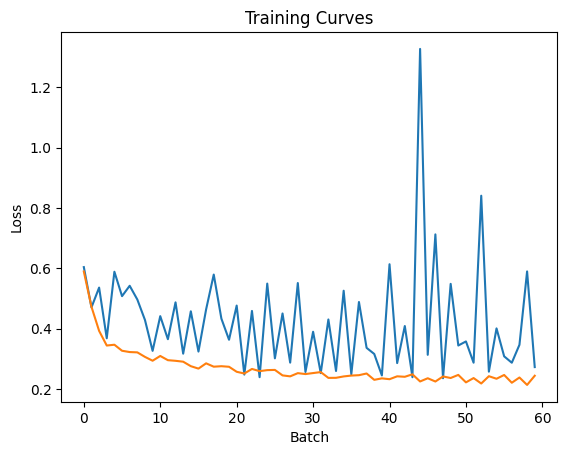

In [97]:
plt.plot(training_losses)
plt.plot(val_losses)
plt.xlabel("Batch")
plt.title('Training Curves')
plt.ylabel("Loss")
plt.show()

### Finding Disallowed Peptides

In [98]:
def is_disallowed(pep1, idx1, pep2, idx2, feature_fxn, sim_fxn, sim_threshold):
    if sim_fxn(feature_fxn(pep1), feature_fxn(pep2)) >= sim_threshold:
        return True
    else:
        return False

In [99]:
pairs = [(idx, idx2) for idx, pep1 in enumerate(peps) for idx2, pep2 in enumerate(peps[idx + 1:]) if is_disallowed(pep1, idx, pep2, idx2, dummy_embed, ratio_similarity, 0.6)]

In [100]:
pairs

[(0, 19), (3, 19), (44, 14), (66, 30), (90, 5)]

In [58]:
def gen_vectorization(seq, mapping_table):
    return np.stack([(mapping_table.loc[s]) for s in seq])


def dataset_mapping(dset, mapping_table):
    return np.array([gen_vectorization(dset[i], mapping_table) for i in range(len(dset))])

In [57]:
aa_prop = pd.DataFrame(map(lambda x: x.split(","),
                               ("1.29,0.9,0,0.049,1.8,0,0,0.047,0.065,0.78,67,1,0,0,1;"
                                "1.11,0.74,0,0.02,2.5,-2,0,0.015,0.015,0.8,86,1,1,-1,0;"
                                "1.04,0.72,-1,0.051,-3.5,-2,1,0.071,0.074,1.41,91,1,0,1;"
                                "1.44,0.75,-1,0.051,-3.5,-2,1,0.094,0.089,1,109,1,0,1,0;"
                                "1.07,1.32,0,0.051,2.8,0,0,0.021,0.029,0.58,135,1,1,-1,0;"
                                "0.56,0.92,0,0.06,-0.4,0,0,0.071,0.07,1.64,48,1,0,1,1;"
                                "1.22,1.08,0,0.034,-3.2,1,1,0.022,0.025,0.69,118,1,0,-1,0;"
                                "0.97,1.45,0,0.047,4.5,0,0,0.032,0.035,0.51,124,1,1,-1,0;"
                                "1.23,0.77,1,0.05,-3.9,2,1,0.105,0.08,0.96,135,1,0,1,0;"
                                "1.3,1.02,0,0.078,3.8,0,0,0.052,0.063,0.59,124,1,1,-1,1;"
                                "1.47,0.97,0,0.027,1.9,0,0,0.017,0.016,0.39,124,1,1,1,0;"
                                "0.9,0.76,0,0.058,-3.5,0,1,0.062,0.053,1.28,96,1,0,1,1;"
                                "0.52,0.64,0,0.051,-1.6,0,0,0.052,0.054,1.91,90,1,0,1,0;"
                                "1.27,0.8,0,0.051,-3.5,1,1,0.053,0.051,0.97,114,1,0,1,0;"
                                "0.96,0.99,1,0.066,-4.5,2,1,0.068,0.059,0.88,148,1,0,1,1;"
                                "0.82,0.95,0,0.057,-0.8,-1,1,0.072,0.071,1.33,73,1,0,1,1;"
                                "0.82,1.21,0,0.064,-0.7,-1,0,0.064,0.065,1.03,93,1,0,0,1;"
                                "0.91,1.49,0,0.049,4.2,0,0,0.048,0.048,0.47,105,1,1,-1,0;"
                                "0.99,1.14,0,0.022,-0.9,1,1,0.007,0.012,0.75,163,1,1,-1,0;"
                                "0.72,1.25,0,0.07,-1.3,-1,1,0.032,0.033,1.05,141,1,1,-1,1").split(";")),
                           columns=['alpha', 'beta', 'charge', 'core', 'hydropathy', 'pH', 'polarity', 'rim', 'surface', 'turn', 'volume', 'strength', 'disorder', 'high_contact', 'count'],
                           index=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

aa_prop = aa_prop.astype(float)
aa_prop

,alpha,beta,charge,core,hydropathy,pH,polarity,rim,surface,turn,volume,strength,disorder,high_contact,count
A,1.29,0.90,0.0,0.049,1.8,0.0,0.0,0.047,0.065,0.78,67.0,1.0,0.0,0.0,1.0
C,1.11,0.74,0.0,0.020,2.5,-2.0,0.0,0.015,0.015,0.80,86.0,1.0,1.0,-1.0,0.0
D,1.04,0.72,-1.0,0.051,-3.5,-2.0,1.0,0.071,0.074,1.41,91.0,1.0,0.0,1.0,NaN
E,1.44,0.75,-1.0,0.051,-3.5,-2.0,1.0,0.094,0.089,1.00,109.0,1.0,0.0,1.0,0.0
F,1.07,1.32,0.0,0.051,2.8,0.0,0.0,0.021,0.029,0.58,135.0,1.0,1.0,-1.0,0.0
G,0.56,0.92,0.0,0.060,-0.4,0.0,0.0,0.071,0.070,1.64,48.0,1.0,0.0,1.0,1.0
H,1.22,1.08,0.0,0.034,-3.2,1.0,1.0,0.022,0.025,0.69,118.0,1.0,0.0,-1.0,0.0
I,0.97,1.45,0.0,0.047,4.5,0.0,0.0,0.032,0.035,0.51,124.0,1.0,1.0,-1.0,0.0
K,1.23,0.77,1.0,0.050,-3.9,2.0,1.0,0.105,0.080,0.96,135.0,1.0,0.0,1.0,0.0
L,1.30,1.02,0.0,0.078,3.8,0.0,0.0,0.052,0.063,0.59,124.0,1.0,1.0,-1.0,1.0


In [59]:
dataset_mapping(random.sample(list(np.unique(vdjdb['Epitope'])), 100), aa_prop)

/tmp/ipykernel_1128390/3868959576.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([gen_vectorization(dset[i], mapping_table) for i in range(len(dset))])


array([array([[ 9.70e-01,  1.45e+00,  0.00e+00,  4.70e-02,  4.50e+00,  0.00e+00,
                0.00e+00,  3.20e-02,  3.50e-02,  5.10e-01,  1.24e+02,  1.00e+00,
                1.00e+00, -1.00e+00,  0.00e+00],
              [ 5.20e-01,  6.40e-01,  0.00e+00,  5.10e-02, -1.60e+00,  0.00e+00,
                0.00e+00,  5.20e-02,  5.40e-02,  1.91e+00,  9.00e+01,  1.00e+00,
                0.00e+00,  1.00e+00,  0.00e+00],
              [ 9.70e-01,  1.45e+00,  0.00e+00,  4.70e-02,  4.50e+00,  0.00e+00,
                0.00e+00,  3.20e-02,  3.50e-02,  5.10e-01,  1.24e+02,  1.00e+00,
                1.00e+00, -1.00e+00,  0.00e+00],
              [ 1.27e+00,  8.00e-01,  0.00e+00,  5.10e-02, -3.50e+00,  1.00e+00,
                1.00e+00,  5.30e-02,  5.10e-02,  9.70e-01,  1.14e+02,  1.00e+00,
                0.00e+00,  1.00e+00,  0.00e+00],
              [ 1.29e+00,  9.00e-01,  0.00e+00,  4.90e-02,  1.80e+00,  0.00e+00,
                0.00e+00,  4.70e-02,  6.50e-02,  7.80e-01,  6.70e+01,  1.00

## Graveyard

In [13]:

from transformers.pipelines import FeatureExtractionPipeline, AggregationStrategy

class PeptideExtractionPipeline(FeatureExtractionPipeline):
    def __init__(self, model, tokenizer, *args, **kwargs):
        super().__init__(
            model,
            tokenizer,
            *args,
            **kwargs
        )

    def _forward(self, model_inputs):
        model_inputs = self.ensure_tensor_on_device(**model_inputs)
        outputs = self.model(**model_inputs)
        logits = outputs.logits
        hidden_state = outputs.hidden_states[-1]

        return {
            "logits": logits,
            "hidden_state": hidden_state,  # Add hidden state to the returned dictionary
        }

    def postprocess(self, model_outputs):
        return model_outputs["hidden_state"]

2023-06-14 20:04:37.250602: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-14 20:04:37.380912: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
pipe = PeptideExtractionPipeline(model=_ESM2_MODEL, tokenizer=_ESM2_TOKENIZER, batch_size=1, device='cpu')
pipe('AVFDRKSDAK').shape

torch.Size([1, 12, 320])

In [24]:
predictions = [pipe(epi) for epi in data_df2['Epitope'].values]



In [15]:
pipe.device

device(type='cpu')

In [23]:
import psutil
import ray

num_cpus = psutil.cpu_count(logical=True)
print('Number of available CPUs:', num_cpus)

# Start Ray cluster
ray.init(num_cpus=num_cpus-4, ignore_reinit_error=True)

"""
The command ray.put(x) would be run by a worker process or by the driver process (the driver process is the one running your script). 
It takes a Python object and copies it to the local object store (here local means on the same node). 
Once the object has been stored in the object store, its value cannot be changed.
In addition, ray.put(x) returns an object ID, which is essentially an ID that can be used to refer to the newly created remote object. 
If we save the object ID in a variable with x_id = ray.put(x), 
then we can pass x_id into remote functions, 
and those remote functions will operate on the corresponding remote object.
"""
pipe_id = ray.put(pipe)

# @ray.remote decorator enables to use this 
# function in distributed setting
@ray.remote
def predict(pipeline, inp):
    return pipeline(inp)


# Run the function using multiple cores and gather the results

predictions = ray.get([predict.remote(pipe_id, epi) for epi in data_df2['Epitope'].values])

# Stop running Ray cluster
ray.shutdown()


Number of available CPUs: 20


2023-06-14 20:07:56,907	INFO worker.py:1636 -- Started a local Ray instance.


In [22]:
predictions[].shape

torch.Size([1, 12, 320])

In [41]:
inps = _ESM2_TOKENIZER("CASSLARDIPRDF", padding=True, truncation=True, max_length=15, return_tensors='pt')
with torch.no_grad():
    print(_ESM2_MODEL(**inps).hidden_states[-1].shape)

torch.Size([1, 15, 320])
